In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
num_epochs = 5
batch_size = 4
learning_rate = 0.001

In [6]:
# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

In [9]:
# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class

train_dataset = torchvision.datasets.CIFAR10(root='/home/iai/Desktop/Jeewon/Study/PyTorch/data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='/home/iai/Desktop/Jeewon/Study/PyTorch/data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

100.0%


Extracting /home/iai/Desktop/Jeewon/Study/PyTorch/data/cifar-10-python.tar.gz to /home/iai/Desktop/Jeewon/Study/PyTorch/data
Files already downloaded and verified


In [11]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [12]:
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [14]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

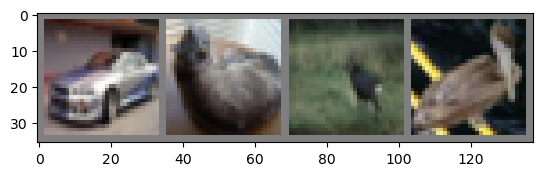

In [15]:
imshow(torchvision.utils.make_grid(images))

In [16]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self,x):
        # -> n, 3, 32, 32 (CIFAR10 - 32*32)
        x = self.pool(F.relu(self.conv1(x))) # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x))) # -> n, 16, 5, 5
        x = x.view(-1, 16*5*5) # -> n, 400
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [17]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [18]:
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')

Epoch [1/5], Step [2000/12500], Loss: 2.3295
Epoch [1/5], Step [4000/12500], Loss: 2.2428
Epoch [1/5], Step [6000/12500], Loss: 2.2972
Epoch [1/5], Step [8000/12500], Loss: 2.2055
Epoch [1/5], Step [10000/12500], Loss: 2.1672
Epoch [1/5], Step [12000/12500], Loss: 2.0406
Epoch [2/5], Step [2000/12500], Loss: 2.0235
Epoch [2/5], Step [4000/12500], Loss: 2.2378
Epoch [2/5], Step [6000/12500], Loss: 2.0927
Epoch [2/5], Step [8000/12500], Loss: 1.6071
Epoch [2/5], Step [10000/12500], Loss: 1.8087
Epoch [2/5], Step [12000/12500], Loss: 1.9945
Epoch [3/5], Step [2000/12500], Loss: 2.9719
Epoch [3/5], Step [4000/12500], Loss: 1.2447
Epoch [3/5], Step [6000/12500], Loss: 1.7847
Epoch [3/5], Step [8000/12500], Loss: 1.5910
Epoch [3/5], Step [10000/12500], Loss: 1.2583
Epoch [3/5], Step [12000/12500], Loss: 1.1334
Epoch [4/5], Step [2000/12500], Loss: 1.1811
Epoch [4/5], Step [4000/12500], Loss: 1.2995
Epoch [4/5], Step [6000/12500], Loss: 0.8933
Epoch [4/5], Step [8000/12500], Loss: 1.2285
Epoc

In [20]:
# Test phase
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')
    

Accuracy of the network: 49.81 %
Accuracy of plane: 52.4 %
Accuracy of car: 55.6 %
Accuracy of bird: 42.7 %
Accuracy of cat: 37.9 %
Accuracy of deer: 37.8 %
Accuracy of dog: 37.2 %
Accuracy of frog: 57.2 %
Accuracy of horse: 53.3 %
Accuracy of ship: 70.3 %
Accuracy of truck: 53.7 %
